## Preparation

##### Import Functions

In [1]:
from Scripts.LoadImage import LoadImage as LoadImage
from Scripts.Fuzzify import Fuzzify as Fuzzify
from Class.Helper import Helper as Helper
from Scripts.Ki67 import Ki67 as Ki67

In [2]:
import numpy as np
import pandas as pd
from os import listdir
from skimage import io
from skimage.draw import circle, circle_perimeter
from matplotlib import pyplot as plt
from skimage.color import rgb2hsv, rgb2hed, hed2rgb, rgb2gray

##### Functions

In [4]:
def getRecall(markers, mask):
    radius = 3
    hits = markers.apply(lambda marker: mask[int(marker['y'])-radius:int(marker['y']) + radius + 1, int(marker['x'])-radius:int(marker['x']) + radius + 1].any(),axis=1)
    recall = hits.sum() / len(hits)
    return recall

def validateResults(folder_name, low_x, high_x, low_y, high_y, show_images = False):
    path = settings.data_folder_veryfication
    mask = pickle.load(open(settings.backup_folder + "Images/" + "Test_" + folder_name + "_" + settings.class_1 + "_df_results"  + ".p", "rb"))
    mask = mask.sort_index()
    
    if settings.class_1 == "brown":
        searched_class = 1
    else:
        searched_class = 2
    
    mask = np.reshape(np.array(mask["Decision Fuzzy"]), (-1, high_x - low_x))
    
    mask = [np.ones(3) if j == settings.class_1 else np.zeros(3) for row in mask for j in row]
    mask = np.array(mask)
    mask = mask.reshape((-1, high_x - low_x, 3))

    from skimage.morphology import binary_closing
    from skimage.morphology import disk, remove_small_objects
    from skimage.color import rgb2gray
    from skimage import data, io, segmentation, color

    file_path = path + folder_name
    image_raw= io.imread(file_path + "/fragment.png")
    base = io.imread(file_path + "/base.png")
    markers = pd.read_csv(file_path + "/markers.csv")

#     k = 1000 / base.shape[1]
    k = 3
    markers.loc[:, 'x'] = markers.x.apply(lambda x: np.ceil(x / k))
    markers.loc[:, 'y'] = markers.y.apply(lambda y: np.ceil(y / k))
    markers = markers.drop(markers[((markers.x < low_x) | (markers.x > high_x)) | ((markers.y < low_y) | (markers.y > high_y))].index)
    markers.loc[:, 'x'] = markers.x.apply(lambda x: x - low_x)
    markers.loc[:, 'y'] = markers.y.apply(lambda y: y - low_y)

    markers = markers.loc[markers.type == searched_class]

    if show_images:
        fig, ax = plt.subplots(ncols=5, nrows=1, figsize=(70, 45))
    mask_gray = rgb2gray(mask)
    if show_images:
        ax[0].imshow(mask, cmap=plt.cm.gray)
    mask_gray = binary_closing(mask_gray, disk(1))
    if show_images:
        ax[1].imshow(mask_gray, cmap=plt.cm.gray)
    mask_gray = remove_small_objects(mask_gray, 3)
    if show_images:
        ax[2].imshow(mask_gray, cmap=plt.cm.gray)
    mask_gray = binary_closing(mask_gray, disk(2))
    if show_images:
        ax[3].imshow(mask_gray, cmap=plt.cm.gray)

    mask_gray = mask_gray.astype(bool)
    recall = getRecall(markers, mask_gray)
    
    if show_images:
        for center_y, center_x in zip(markers.y, markers.x):
            circy, circx = circle_perimeter(int(center_y), int(center_x), 0)
            image_raw[circy, circx] = (220, 20, 20)
        
        ax[4].imshow(image_raw, cmap=plt.cm.gray)
        plt.show()
        
    return recall

##### Import Settings

In [363]:
from Settings.SettingsKi67 import Settings as Settings
import Settings.GeneralSettings as generalSettings
settings = Settings(generalSettings)

##### Load Image

In [364]:
loadImage = LoadImage()
samples_stats, train_stats, test_stats, train_samples = loadImage.worker(settings, test_mode = False)

../Data/Ki67-Train/backgoround.png
../Data/Ki67-Train/blue.png
../Data/Ki67-Train/brown.png


### Train mode

In [262]:
fuzzify = Fuzzify()
changed_decisions, features_number_after_reduct, implicants_number, fuzzify_parameters, execution_time = fuzzify.worker(settings, -1)

In [15]:
from Settings.SettingsKi67 import Settings as Settings
import Settings.GeneralSettings as generalSettings


for cell_type in ["brown"]:
    generalSettings.gausses = 5
    generalSettings.style = "Gaussian Equal"
    generalSettings.adjustment_value = -1
    generalSettings.class_1 = cell_type
    generalSettings.features_type = 12
    settings = Settings(generalSettings)        

    # Generate Rules
    loadImage = LoadImage()
    samples_stats, train_stats, test_stats, train_samples = loadImage.worker(settings, test_mode = False)

    fuzzify = Fuzzify()
    changed_decisions, features_number_after_reduct, implicants_number, fuzzify_parameters, execution_time = fuzzify.worker(settings, -1)

    # Validate Results
    for file_name in ["1628-05", "18583-04", "31374-10",]:
        generalSettings.file_name = file_name
        settings = Settings(generalSettings)     
        loadImage = LoadImage()
        samples_stats, train_stats, test_stats, train_samples = loadImage.worker(settings, test_mode = -1)

        ki67Test = Ki67(settings, settings.s_function_width, False)
        ki67Test.noOptymalizationWorker(settings)

        if file_name == "1628-05":
            recall_1 = validateResults(settings.file_name, 85, 449, 172, 533, False)
        elif file_name == "18583-04":
            recall_2 = validateResults(settings.file_name, 1732, 2011, 583, 995, False)
        else:
            recall_3 = validateResults(settings.file_name, 432, 794, 300, 566, False)
    avg_recall = (recall_1 + recall_2 + recall_3) / 3
    helper = Helper()

    fuzzification_data = ["Ki67", settings.style, settings.gausses, settings.adjustment, settings.class_1, settings.features_type, samples_stats, train_stats, test_stats, changed_decisions, round(changed_decisions / train_samples, 2), implicants_number, settings.feature_numbers, features_number_after_reduct, recall_1, recall_2, recall_3, avg_recall, execution_time]
    helper.saveFuzzificationStatsKi67(fuzzification_data)

../Data/Ki67-Train/backgoround.png
../Data/Ki67-Train/blue.png
../Data/Ki67-Train/brown.png
../Data/Ki67-Veryfication/1628-05/fragment.png



  3%|██▌                                                                        | 4517/131404 [00:09<04:36, 458.62it/s]


  7%|████▉                                                                      | 8608/131404 [00:18<06:05, 336.12it/s]


 10%|███████▏                                                                  | 12722/131404 [00:29<07:13, 273.96it/s]


 13%|█████████▍                                                                | 16831/131404 [00:40<05:13, 365.54it/s]


 16%|███████████▊                                                              | 20953/131404 [00:50<04:07, 445.54it/s]


 19%|██████████████▏                                                           | 25235/131404 [01:00<04:04, 434.68it/s]


 22%|████████████████▌                                                         | 29302/131404 [01:11<03:55, 433.35it/s]


 25%|██████████████████▋                                                       | 33099/131404 [01:21<06:22, 256.88it/s]


 28%|████████████████████▋                                                     | 36656/131404 [01:31<05:26, 290.24it/s]


 31%|██████████████████████▋                                                   | 40217/131404 [01:41<03:39, 414.79it/s]


 33%|████████████████████████▋                                                 | 43905/131404 [01:52<03:33, 410.63it/s]


 36%|██████████████████████████▊                                               | 47599/131404 [02:03<04:25, 315.55it/s]


 39%|████████████████████████████▉                                             | 51290/131404 [02:14<04:24, 303.20it/s]


 42%|███████████████████████████████▏                                          | 55335/131404 [02:24<04:29, 282.57it/s]


 45%|█████████████████████████████████▍                                        | 59473/131404 [02:35<03:50, 312.01it/s]


 48%|███████████████████████████████████▋                                      | 63374/131404 [02:46<03:46, 300.18it/s]


 51%|█████████████████████████████████████▉                                    | 67400/131404 [02:56<02:45, 386.30it/s]


 55%|████████████████████████████████████████▍                                 | 71907/131404 [03:07<02:33, 387.14it/s]


 58%|███████████████████████████████████████████▏                              | 76737/131404 [03:19<02:02, 447.57it/s]


 61%|█████████████████████████████████████████████▍                            | 80591/131404 [03:29<02:51, 296.27it/s]


 64%|███████████████████████████████████████████████                           | 83578/131404 [03:39<03:16, 243.93it/s]


 66%|████████████████████████████████████████████████▌                         | 86159/131404 [03:48<03:25, 220.00it/s]


 67%|█████████████████████████████████████████████████▉                        | 88673/131404 [03:57<03:22, 210.71it/s]


 69%|███████████████████████████████████████████████████▏                      | 90867/131404 [04:06<02:54, 231.93it/s]


 71%|████████████████████████████████████████████████████▌                     | 93363/131404 [04:15<02:20, 270.83it/s]


 73%|█████████████████████████████████████████████████████▉                    | 95814/131404 [04:25<02:39, 223.65it/s]


 75%|███████████████████████████████████████████████████████▎                  | 98285/131404 [04:34<02:12, 249.02it/s]


 77%|███████████████████████████████████████████████████████▉                 | 100707/131404 [04:43<02:11, 233.49it/s]


 79%|█████████████████████████████████████████████████████████▍               | 103317/131404 [04:52<02:11, 213.31it/s]


 81%|██████████████████████████████████████████████████████████▉              | 106064/131404 [05:01<01:14, 341.47it/s]


 83%|████████████████████████████████████████████████████████████▍            | 108724/131404 [05:11<01:26, 261.58it/s]


 85%|█████████████████████████████████████████████████████████████▊           | 111190/131404 [05:20<01:41, 199.66it/s]


 87%|███████████████████████████████████████████████████████████████▏         | 113722/131404 [05:30<01:22, 215.12it/s]


 88%|████████████████████████████████████████████████████████████████▌        | 116222/131404 [05:40<01:08, 222.26it/s]


 90%|█████████████████████████████████████████████████████████████████▉       | 118789/131404 [05:50<01:02, 202.23it/s]


 93%|███████████████████████████████████████████████████████████████████▋     | 121920/131404 [06:01<00:37, 250.67it/s]


 96%|█████████████████████████████████████████████████████████████████████▊   | 125751/131404 [06:12<00:20, 278.13it/s]


 99%|████████████████████████████████████████████████████████████████████████▌| 130514/131404 [06:21<00:01, 583.19it/s]


100%|█████████████████████████████████████████████████████████████████████████| 131404/131404 [06:26<00:00, 340.35it/s]

-----------------------------------------------------------------------------------
Time: 402.3846733570099
-----------------------------------------------------------------------------------
../Data/Ki67-Veryfication/18583-04/fragment.png



  3%|██▏                                                                        | 3418/114948 [00:11<06:16, 296.37it/s]


  6%|████▎                                                                      | 6601/114948 [00:22<09:33, 189.07it/s]


  8%|██████▏                                                                    | 9413/114948 [00:33<09:09, 192.14it/s]


 11%|████████▏                                                                 | 12691/114948 [00:44<05:56, 286.77it/s]


 14%|██████████▌                                                               | 16407/114948 [00:55<05:37, 292.23it/s]


 18%|█████████████▏                                                            | 20426/114948 [01:06<04:27, 353.92it/s]


 20%|██████████████▋                                                           | 22785/114948 [01:15<07:34, 202.72it/s]


 22%|████████████████                                                          | 24861/114948 [01:24<06:10, 243.36it/s]


 23%|█████████████████▎                                                        | 26924/114948 [01:32<06:55, 211.92it/s]


 25%|██████████████████▋                                                       | 28998/114948 [01:41<06:30, 220.25it/s]


 27%|███████████████████▉                                                      | 31000/114948 [01:49<05:38, 247.82it/s]


 29%|█████████████████████▏                                                    | 32896/114948 [01:58<07:00, 194.92it/s]


 30%|██████████████████████▌                                                   | 35047/114948 [02:06<06:10, 215.57it/s]


 32%|████████████████████████                                                  | 37318/114948 [02:16<06:13, 207.60it/s]


 35%|█████████████████████████▌                                                | 39732/114948 [02:25<05:19, 235.19it/s]


 37%|███████████████████████████▏                                              | 42238/114948 [02:34<04:33, 266.17it/s]


 39%|████████████████████████████▊                                             | 44778/114948 [02:44<04:51, 240.63it/s]


 41%|██████████████████████████████                                            | 46663/114948 [02:52<04:19, 263.20it/s]


 42%|███████████████████████████████▏                                          | 48444/114948 [03:00<05:23, 205.85it/s]


 44%|████████████████████████████████▏                                         | 50040/114948 [03:08<05:05, 212.33it/s]


 45%|█████████████████████████████████▏                                        | 51558/114948 [03:15<05:12, 202.65it/s]


 46%|██████████████████████████████████                                        | 52978/114948 [03:22<05:24, 190.71it/s]


 47%|██████████████████████████████████▉                                       | 54313/114948 [03:30<06:18, 160.19it/s]


 49%|███████████████████████████████████▉                                      | 55776/114948 [03:37<05:04, 194.07it/s]


 50%|████████████████████████████████████▊                                     | 57159/114948 [03:45<06:30, 148.10it/s]


 51%|█████████████████████████████████████▊                                    | 58687/114948 [03:53<04:56, 189.71it/s]


 52%|██████████████████████████████████████▊                                   | 60223/114948 [04:01<05:02, 181.15it/s]


 54%|███████████████████████████████████████▊                                  | 61805/114948 [04:09<04:33, 194.45it/s]


 55%|████████████████████████████████████████▊                                 | 63333/114948 [04:17<04:41, 183.50it/s]


 56%|█████████████████████████████████████████▊                                | 64880/114948 [04:24<03:54, 213.37it/s]


 58%|██████████████████████████████████████████▊                               | 66424/114948 [04:32<03:59, 202.61it/s]


 59%|███████████████████████████████████████████▊                              | 68024/114948 [04:40<04:09, 187.80it/s]


 61%|█████████████████████████████████████████████                             | 70014/114948 [04:48<03:43, 201.18it/s]


 63%|██████████████████████████████████████████████▌                           | 72384/114948 [04:58<03:07, 226.44it/s]


 65%|████████████████████████████████████████████████                          | 74738/114948 [05:07<03:11, 210.02it/s]


 67%|█████████████████████████████████████████████████▊                        | 77366/114948 [05:16<02:24, 260.88it/s]


 70%|███████████████████████████████████████████████████▌                      | 80083/114948 [05:25<02:11, 264.47it/s]


 72%|█████████████████████████████████████████████████████▍                    | 83097/114948 [05:36<02:27, 215.90it/s]


 75%|███████████████████████████████████████████████████████▎                  | 86011/114948 [05:46<01:51, 258.50it/s]


 78%|█████████████████████████████████████████████████████████▍                | 89163/114948 [05:56<01:37, 264.86it/s]


 80%|███████████████████████████████████████████████████████████▍              | 92330/114948 [06:06<01:16, 294.40it/s]


 83%|█████████████████████████████████████████████████████████████▍            | 95499/114948 [06:16<01:11, 272.13it/s]


 86%|███████████████████████████████████████████████████████████████▋          | 98912/114948 [06:28<01:08, 235.56it/s]


 90%|█████████████████████████████████████████████████████████████████▍       | 103001/114948 [06:38<00:25, 474.28it/s]


 94%|████████████████████████████████████████████████████████████████████▎    | 107629/114948 [06:49<00:14, 517.99it/s]


 98%|███████████████████████████████████████████████████████████████████████▍ | 112537/114948 [06:57<00:04, 517.98it/s]


100%|█████████████████████████████████████████████████████████████████████████| 114948/114948 [07:04<00:00, 270.92it/s]

-----------------------------------------------------------------------------------
Time: 438.27178978919983
-----------------------------------------------------------------------------------
../Data/Ki67-Veryfication/31374-10/fragment.png



  2%|█▌                                                                          | 2005/96292 [00:08<06:50, 229.47it/s]


  4%|███▏                                                                        | 3973/96292 [00:16<07:23, 208.07it/s]


  6%|████▊                                                                       | 6110/96292 [00:25<07:50, 191.84it/s]


  8%|██████▍                                                                     | 8165/96292 [00:34<06:32, 224.59it/s]


 10%|███████▊                                                                   | 10043/96292 [00:42<07:20, 195.90it/s]


 12%|█████████▏                                                                 | 11721/96292 [00:50<07:11, 196.12it/s]


 14%|██████████▍                                                                | 13362/96292 [00:58<07:23, 187.09it/s]


 16%|███████████▋                                                               | 14941/96292 [01:05<07:25, 182.63it/s]


 17%|████████████▊                                                              | 16470/96292 [01:13<06:08, 216.66it/s]


 19%|██████████████▏                                                            | 18193/96292 [01:21<05:55, 219.88it/s]


 21%|███████████████▍                                                           | 19880/96292 [01:29<07:04, 179.95it/s]


 22%|████████████████▊                                                          | 21630/96292 [01:37<06:18, 197.41it/s]


 24%|██████████████████▏                                                        | 23388/96292 [01:45<05:33, 218.46it/s]


 26%|███████████████████▌                                                       | 25194/96292 [01:53<05:37, 210.96it/s]


 28%|█████████████████████                                                      | 26980/96292 [02:01<06:34, 175.72it/s]


 30%|██████████████████████▎                                                    | 28709/96292 [02:08<05:41, 197.77it/s]


 31%|███████████████████████▌                                                   | 30323/96292 [02:16<05:29, 200.48it/s]


 33%|████████████████████████▊                                                  | 31931/96292 [02:24<04:54, 218.78it/s]


 35%|██████████████████████████▏                                                | 33597/96292 [02:31<04:49, 216.30it/s]


 37%|███████████████████████████▌                                               | 35313/96292 [02:39<05:24, 188.01it/s]


 38%|████████████████████████████▊                                              | 37050/96292 [02:47<04:18, 229.40it/s]


 40%|██████████████████████████████▎                                            | 38852/96292 [02:55<04:37, 206.84it/s]


 42%|███████████████████████████████▊                                           | 40814/96292 [03:03<03:53, 237.65it/s]


 45%|█████████████████████████████████▍                                         | 42906/96292 [03:12<04:56, 179.82it/s]


 47%|███████████████████████████████████                                        | 45050/96292 [03:21<03:53, 219.88it/s]


 49%|████████████████████████████████████▊                                      | 47310/96292 [03:29<03:27, 235.91it/s]


 51%|██████████████████████████████████████▌                                    | 49514/96292 [03:38<03:41, 211.41it/s]


 53%|████████████████████████████████████████                                   | 51515/96292 [03:46<03:37, 206.32it/s]


 56%|█████████████████████████████████████████▋                                 | 53518/96292 [03:55<04:24, 162.01it/s]


 58%|███████████████████████████████████████████▎                               | 55670/96292 [04:04<03:05, 218.97it/s]


 60%|█████████████████████████████████████████████▏                             | 58068/96292 [04:13<03:00, 211.25it/s]


 63%|███████████████████████████████████████████████                            | 60357/96292 [04:22<02:44, 219.05it/s]


 65%|████████████████████████████████████████████████▋                          | 62547/96292 [04:31<02:38, 212.34it/s]


 67%|██████████████████████████████████████████████████▌                        | 64871/96292 [04:40<01:57, 266.51it/s]


 70%|████████████████████████████████████████████████████▎                      | 67164/96292 [04:49<02:27, 197.42it/s]


 72%|█████████████████████████████████████████████████████▊                     | 69013/96292 [04:58<02:31, 179.91it/s]


 74%|███████████████████████████████████████████████████████▏                   | 70809/96292 [05:06<02:12, 192.01it/s]


 76%|████████████████████████████████████████████████████████▋                  | 72817/96292 [05:15<01:24, 277.91it/s]


 78%|██████████████████████████████████████████████████████████▎                | 74889/96292 [05:24<01:27, 244.19it/s]


 80%|████████████████████████████████████████████████████████████▏              | 77287/96292 [05:33<01:12, 260.98it/s]


 83%|██████████████████████████████████████████████████████████████▎            | 79991/96292 [05:42<00:58, 280.73it/s]


 86%|████████████████████████████████████████████████████████████████▍          | 82753/96292 [05:51<00:58, 232.53it/s]


 89%|██████████████████████████████████████████████████████████████████▌        | 85411/96292 [06:00<00:39, 277.27it/s]


 91%|████████████████████████████████████████████████████████████████████▍      | 87831/96292 [06:09<00:39, 211.85it/s]


 94%|██████████████████████████████████████████████████████████████████████▎    | 90257/96292 [06:18<00:24, 250.05it/s]


 96%|████████████████████████████████████████████████████████████████████████▏  | 92615/96292 [06:27<00:14, 250.08it/s]


 99%|██████████████████████████████████████████████████████████████████████████▏| 95273/96292 [06:36<00:03, 280.62it/s]


100%|███████████████████████████████████████████████████████████████████████████| 96292/96292 [06:41<00:00, 239.61it/s]

-----------------------------------------------------------------------------------
Time: 413.1180763244629
-----------------------------------------------------------------------------------


,Dataset,Style,Gausses,Adjustment,Searched Class,Features type,Samples,Train s.,Test s.,Changed s.,% changed s.,Implicants,Features,F. after reduct,Recall 1,Recall 2,Recall 3,Average Recall,Execution Time
0,Ki67,Gaussian Equal,3,Mean,blue,1,96292 (--/--),-- (--/--),96292 (--/--),5,0.0,27,5,5,0.824242,0.829630,0.430108,0.694660,9.292650
1,Ki67,Gaussian Equal,3,Optymalized,blue,1,96292 (--/--),-- (--/--),96292 (--/--),5,0.0,27,5,5,0.824242,0.829630,0.430108,0.694660,11.349005
2,Ki67,Gaussian Equal,5,Mean,blue,1,96292 (--/--),-- (--/--),96292 (--/--),13,0.0,68,5,5,0.836364,0.837037,0.526882,0.733427,69.863997
3,Ki67,Gaussian Equal,5,Mean,blue,2,96292 (--/--),-- (--/--),96292 (--/--),13,0.0,91,6,6,0.836364,0.837037,0.526882,0.733427,63.533613
4,Ki67,Gaussian Equal,5,Mean,blue,3,96292 (--/--),-- (--/--),96292 (--/--),27,0.0,325,9,9,0.709091,0.718519,0.327957,0.585189,700.514678
5,Ki67,Gaussian Equal,5,Mean,blue,4,96292 (--/--),-- (--/--),96292 (--/--),3,0.0,11,2,2,0.381818,0.496296,0.215054,0.364389,31.548809
6,Ki67,Gaussian Equal,5,Mean,blue,7,96292 (--/--),-- (--/--),96292 (--/--),16,0.0,180,6,6,0.333333,0.422222,0.080645,0.278734,189.062435
7,Ki67,Gaussian Equal,5,Mean,blue,5,96292 (--/--),-- (--/--),96292 (--/--),3,0.0,37,5,5,0.151515,0.222222,0.064516,0.146085,69.059017
8,Ki67,Gaussian Equal,5,Mean,blue,8,96292 (--/--),-- (--/--),96292 (--/--),12,0.0,50,4,4,0.818182,0.837037,0.430108,0.695109,27.919985
9,Ki67,Gaussian Equal,5,Mean,blue,9,96292 (--/--),-- (--/--),96292 (--/--),11,0.0,48,4,4,0.818182,0.837037,0.430108,0.695109,73.989838


### Test mode

In [264]:
loadImage = LoadImage()
samples_stats, train_stats, test_stats, train_samples = loadImage.worker(settings, test_mode = True)

../Data/Ki67-Test/blue.png


In [460]:
ki67Test = Ki67(settings, settings.s_function_width, False)

In [461]:
ki67Test.noOptymalizationWorker(settings)

100%|███████████████████████████████████████████████████████████████████████████| 11020/11020 [00:30<00:00, 360.18it/s]


-----------------------------------------------------------------------------------
Time: 31.962507963180542
-----------------------------------------------------------------------------------


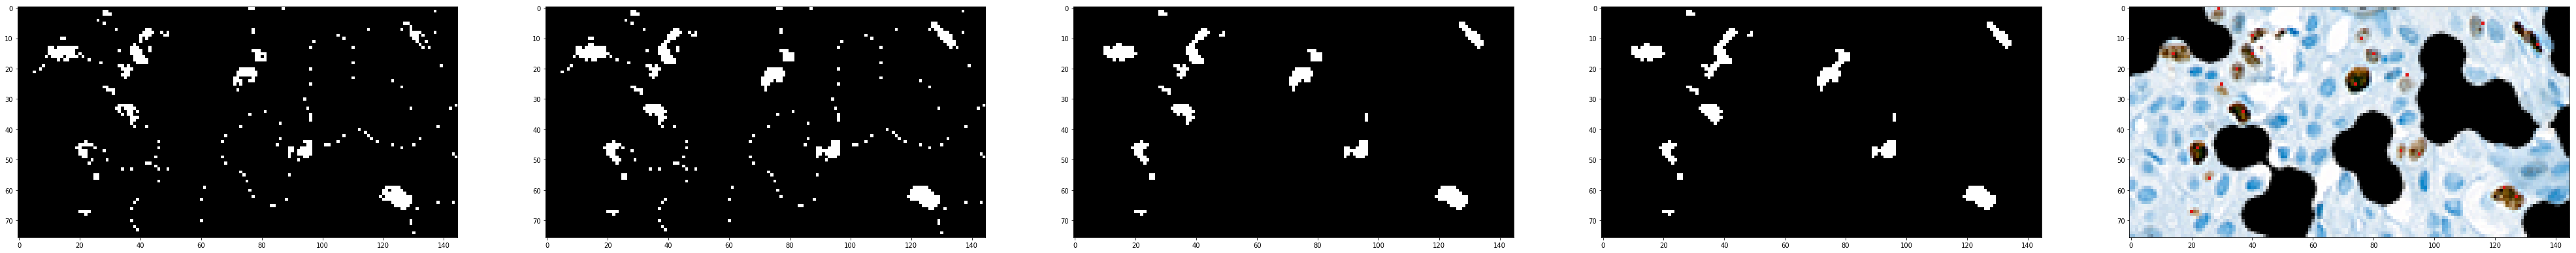

0.8

In [538]:
validateResults(settings.file_name, 405, 550, 68, 144, True)